# Solutions to Exercise 2

[<img src="https://img.shields.io/badge/Documentation-Main_Page-orange.svg?logo=LOGO">](https://mrchem.readthedocs.io/en/latest/)
[<img src="https://img.shields.io/badge/I_Need_Help-Installation-teal.svg?logo=LOGO">](https://mrchem.readthedocs.io/en/latest/installation.html)
[<img src="https://img.shields.io/badge/I_Need_Help-How_To_Run-green.svg?logo=LOGO">](https://mrchem.readthedocs.io/en/latest/users/running.html)
[<img src="https://img.shields.io/badge/I_Need_Help-Input_Quick_Guide-blue.svg?logo=LOGO">](https://mrchem.readthedocs.io/en/latest/users/user_inp.html)
[<img src="https://img.shields.io/badge/I_Need_Help-Input_Reference-purple.svg?logo=LOGO">](https://mrchem.readthedocs.io/en/latest/users/user_ref.html)
[<img src="https://img.shields.io/badge/I_Need_Help-JSON_Output-red.svg?logo=LOGO">](https://mrchem.readthedocs.io/en/latest/users/program_json.html)

The code cells below show how to set up NMR calculations on the water molecule, and how to run the calculation from within the notebook.

In [1]:
import os
import sys
import json
import time
import shutil
import subprocess
import pandas as pd
import matplotlib.pyplot as plt

ROOT = os.path.dirname(os.path.abspath(''))
SOLUTIONS = os.path.join(ROOT, 'solutions')
sys.path.append(ROOT)

from utils.functions import MRChemOutput

## Define some useful functions

In [2]:
def readCoords(f):
    """Read XYZ file and return as MRChem JSON friendly string."""
    with open(f) as file:
        return '\n'.join([line.strip() for line in file.readlines()[2:]])

def makeInput(world_prec=None, xyzfile=None, fname=None):
    """Write MRChem JSON input file."""
    i = {
        'world_prec': world_prec,
        'world_unit': 'angstrom',
        'Molecule': {
            'charge': 0,
            'multiplicity': 1,
            'translate': True,
            'coords': readCoords(xyzfile)
        },
        'WaveFunction': {
            'method': 'pbe', 
            'restricted': True
        },
        'SCF': {
            'guess_type': 'sad_dz',
            'guess_prec': 1e-4,
            'kain': 5,
            'write_orbitals': True,
            'localize': True,
            'max_iter': 40,
            'orbital_thrs': 10 * world_prec
        },
        'Properties': {
            'nmr_shielding': True
        },
        'Response': {
            'max_iter': 40,
            'kain': 5,
            'orbital_thrs': 10 * world_prec
            
        }
    }
    
    with open(fname+'.inp', 'w') as f:
        json.dump(i, f, indent=2)

def submit(nprocs=None, dest=None, inputfile=None):
    """Make calc dir, copy move inputfile, and start the calculation."""
    # Check if all arguments given
    assert not any([nprocs is None, dest is None, inputfile is None]), 'Missing arguments'
    
    # Make calc dir
    if os.path.exists(dest):
        shutil.rmtree(dest)
    os.makedirs(dest)
        
    # Check if input file exists
    if not os.path.exists(inputfile):
        print(f'Error: Input file <{inputfile}> not found')
        return
    
    shutil.move(inputfile, os.path.join(dest, inputfile))
    os.chdir(dest)
    os.environ['OMP_NUM_THREADS'] = str(nprocs)
    subprocess.call(['mrchem', '--json',  inputfile])
    os.chdir(SOLUTIONS)

## Loop over the precisions and run calculations

**ProTip**: You could save some time by reusing the MW3 orbitals as starting guess for the higher precision jobs. How to do this is explained in the documentation:

[<img src="https://img.shields.io/badge/I_Need_Help-MW_Initial_Guess-red.svg?logo=LOGO">](https://mrchem.readthedocs.io/en/latest/users/user_inp.html#write-orbitals)

In [7]:
# Uncomment the makeInput and submit commands
# and delete the time.sleep command to run the calculations
precisions = {'mw3': 1e-3, 'mw4': 1e-4, 'mw5': 1e-5}

mw_results = {}
for i, (label, prec) in enumerate(precisions.items()):
    print(label.upper())
    
    jobname = f'water_nmr_{label}'
    dest = os.path.join(SOLUTIONS, jobname+'_calc')
    xyzfile = '../geometries/water.xyz'

    t0 = time.time()
    # makeInput(world_prec=prec, xyzfile=xyzfile, fname=jobname)
    # submit(nprocs=6, dest=dest, inputfile=jobname+'.inp')
    time.sleep((i+1)**2)
    t1 = time.time()
        
    print(f'   >>> Finished after {t1-t0:.1f} seconds')

MW3
   >>> Finished after 1.0 seconds
MW4
   >>> Finished after 4.0 seconds
MW5
   >>> Finished after 9.0 seconds


## Plot the SCF and response convergence for each job

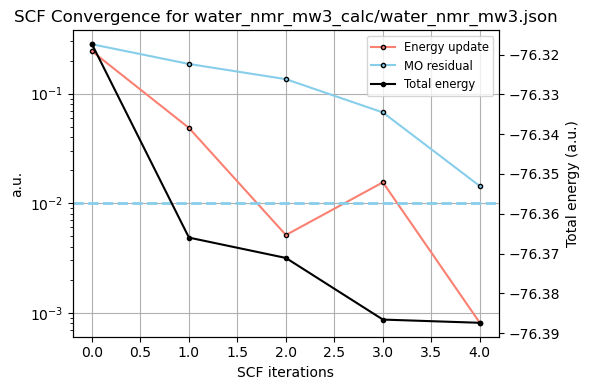

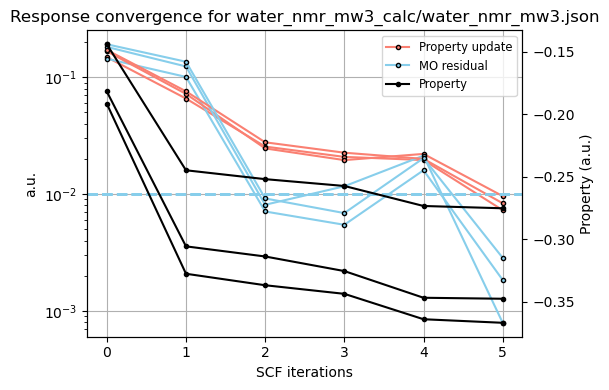

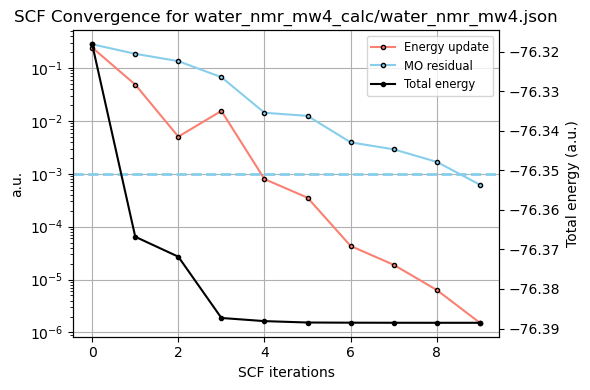

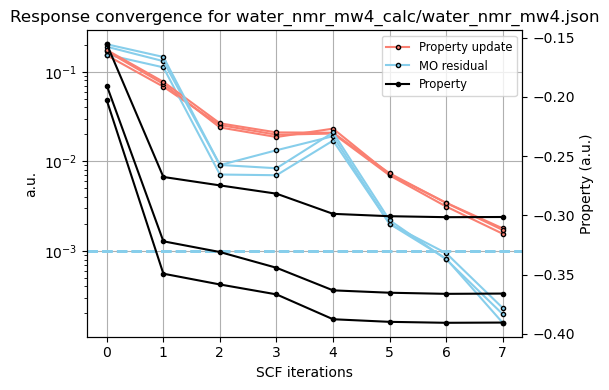

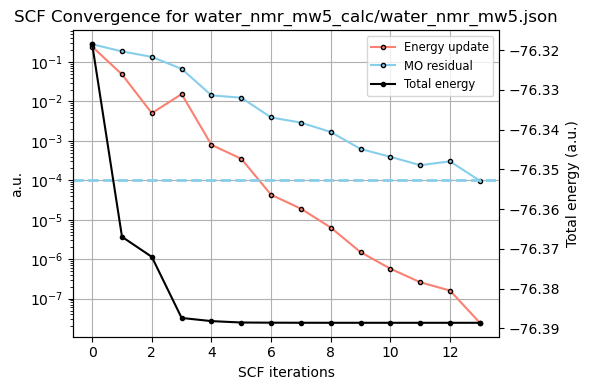

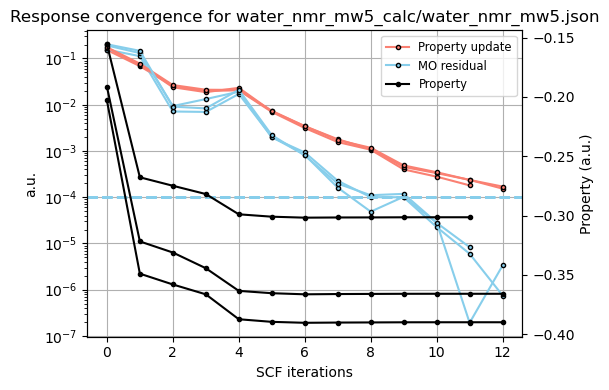

In [8]:
base = 'water_nmr'
precisions = {'mw3': 1e-3, 'mw4': 1e-4, 'mw5': 1e-5}

for label, prec in precisions.items():
    f = os.path.join(f'{base}_{label}_calc', f'{base}_{label}.json')
    calc = MRChemOutput(f)
    
    calc.plotSCFConvergence()
    calc.plotResponseConvergence()

## Collect the isotropic averages and anisotropies

In [87]:
mw_data = []
base = 'water_nmr'
for label, prec in precisions.items():
    f = os.path.join(f'{base}_{label}_calc', f'{base}_{label}.json')
    calc = MRChemOutput(f)
    
    isos = calc.getNMRShieldingIsotropicAverage()
    anisos = calc.getNMRShieldingAnisotropy()
    
    for atom in isos.keys():
        mw_data.append((label, atom[4:].upper(), isos[atom], anisos[atom]))
        
gto_data = [('dz', '0O', 319.317, 52.281),
 ('dz', '1H', 30.918, 18.326),
 ('dz', '2H', 30.918, 18.326),
 ('tz', '0O', 319.156, 52.351),
 ('tz', '1H', 30.766, 18.54),
 ('tz', '2H', 30.766, 18.54),
 ('qz', '0O', 319.183, 52.345),
 ('qz', '1H', 30.715, 18.62),
 ('qz', '2H', 30.715, 18.62),
 ('5z', '0O', 319.158, 52.345),
 ('5z', '1H', 30.71, 18.627),
 ('5z', '2H', 30.71, 18.627)]

df = pd.DataFrame(mw_data + gto_data, columns=['Basis', 'Atom', 'Iso', 'Aniso'])
ref = df.loc[df.Basis == 'mw5']
df = df.merge(ref, how='inner', on='Atom', suffixes=('', '_ref'))
df.drop(df.loc[df.Basis == 'mw5'].index, inplace=True)

df['Error_iso'] = abs(df.Iso - df.Iso_ref) / df.Iso_ref * 100
df['Error_aniso'] = abs(df.Aniso - df.Aniso_ref) / df.Aniso_ref * 100

df = df.sort_values(by=['Error_iso']).reset_index(drop=True)

### Plot errors in isotropic averages

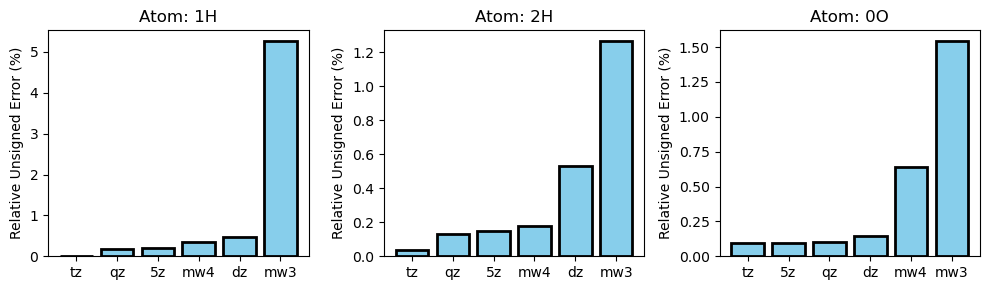

In [95]:
fig, axes = plt.subplots(dpi=100, ncols=3, figsize=(10, 3))

for ax, atom in zip(axes.flat, df.Atom.unique()):
    sub_df = df.loc[df.Atom == atom]
    
    ax.bar(sub_df.Basis, sub_df.Error_iso, edgecolor='black', color='skyblue', lw=2)
    
    ax.set_ylabel('Relative Unsigned Error (%)')
    ax.set_title(f'Atom: {atom}')
    

plt.tight_layout(h_pad=1)

### Plot errors in anisotropies

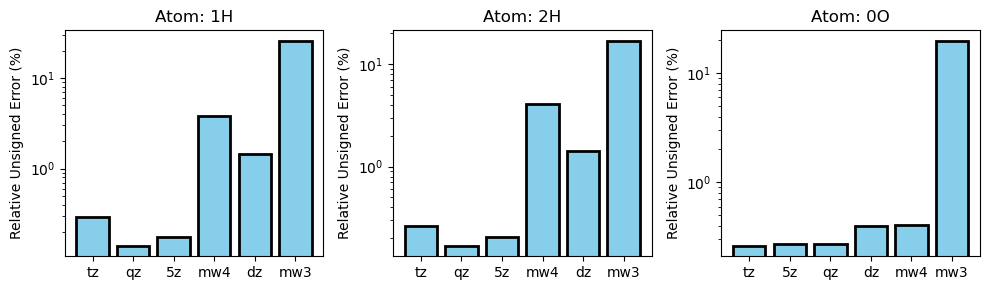

In [94]:
fig, axes = plt.subplots(dpi=100, ncols=3, figsize=(10, 3))

for ax, atom in zip(axes.flat, df.Atom.unique()):
    sub_df = df.loc[df.Atom == atom]
    
    ax.bar(sub_df.Basis, sub_df.Error_aniso, edgecolor='black', color='skyblue', lw=2)
    
    ax.set_yscale('log')
    ax.set_ylabel('Relative Unsigned Error (%)')
    ax.set_title(f'Atom: {atom}')
    

plt.tight_layout(h_pad=1)